# **BC COVID-19 Cases Modeling**
            -- This is project that is still in progress, will be adding recovered case modelling and explore other model to make better predictions
![](./Comparison.png)

In [1]:
import warnings

warnings.filterwarnings('ignore')
# libraries
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2



In [2]:
# Data source
caseDetailsUrl = 'http://www.bccdc.ca/Health-Info-Site/Documents/BCCDC_COVID19_Dashboard_Case_Details.csv'

In [3]:
bcCasesDf = pd.read_csv(caseDetailsUrl)

In [4]:
bcCasesDf.rename(columns={'Reported_Date':'Reported Date', 'HA': 'Health Authority', 'Age_Group': 'Age Group', 'Classification_Reported': 'Classification Reported'}, inplace=True)

In [5]:
bcCasesDf['Reported Date'] = pd.to_datetime(bcCasesDf['Reported Date'])

In [6]:
bcCasesDf['Reported Date'] = pd.DatetimeIndex(bcCasesDf['Reported Date']).normalize()

In [7]:
bcCasesDf.head()

,Reported Date,Health Authority,Sex,Age Group,Classification Reported
0,2020-01-29,Out of Canada,M,40-49,Lab-diagnosed
1,2020-02-06,Vancouver Coastal,F,50-59,Lab-diagnosed
2,2020-02-10,Out of Canada,F,20-29,Lab-diagnosed
3,2020-02-10,Out of Canada,M,30-39,Lab-diagnosed
4,2020-02-18,Interior,F,30-39,Lab-diagnosed


In [8]:
bcCasesDf.shape

(142636, 5)

In [9]:
lastRow = int(bcCasesDf.shape[0])-1

In [10]:
totalDays = bcCasesDf.loc[lastRow, 'Reported Date'] - bcCasesDf.loc[0, 'Reported Date']
firstReported = bcCasesDf['Reported Date'].min()
latestReported = bcCasesDf['Reported Date'].max()

In [11]:
# check the oldest and latest record
print(f'This data is for a period between {firstReported.strftime("%d %B %Y")} and {latestReported.strftime("%d %B %Y")}')
print(f"For a total of {totalDays.days} days")

This data is for a period between 29 January 2020 and 24 May 2021
For a total of 481 days


In [12]:
currentDatePlusMonth = datetime.now() + relativedelta(days=+40)

In [13]:
bcCasesDf['Classification Reported'].unique()

array(['Lab-diagnosed', 'Epi-linked'], dtype=object)

**Meaning of Epi-linked: http://www.bccdc.ca/health-professionals/clinical-resources/case-definitions/covid-19-(novel-coronavirus)**
Probable - epi-linked case
A person who:

**Has symptoms b compatible with COVID-19
AND**

**Had a high-risk exposure with a confirmed d COVID-19 case (i.e. close contact) OR was exposed to a known cluster or outbreak of COVID-19
 AND**

**Has not had a laboratory-based NAAT assay for SARS-CoV-2 completed** 

In [14]:
print('Percentage Lab Diagnosed:{:.2f}'.format(bcCasesDf['Classification Reported'][bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[0]].count()/bcCasesDf['Reported Date'].count()*100))
print('Percentage Epi-Linked:{:.2f}'.format(bcCasesDf['Classification Reported'][bcCasesDf['Classification Reported'] != bcCasesDf['Classification Reported'].unique()[0]].count()/bcCasesDf['Reported Date'].count()*100))


Percentage Lab Diagnosed:99.24
Percentage Epi-Linked:0.76


In [15]:
bcCasesDf['Diagnosed'] = np.where(bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[0], 1,
                          np.where(bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[1], np.nan, np.nan))

# **Daily BC cases**

In [16]:
data = bcCasesDf.groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count()
data.reset_index()
data.head()

Reported Date
2020-01-29    1
2020-01-30    0
2020-01-31    0
2020-02-01    0
2020-02-02    0
Freq: D, Name: Diagnosed, dtype: int64

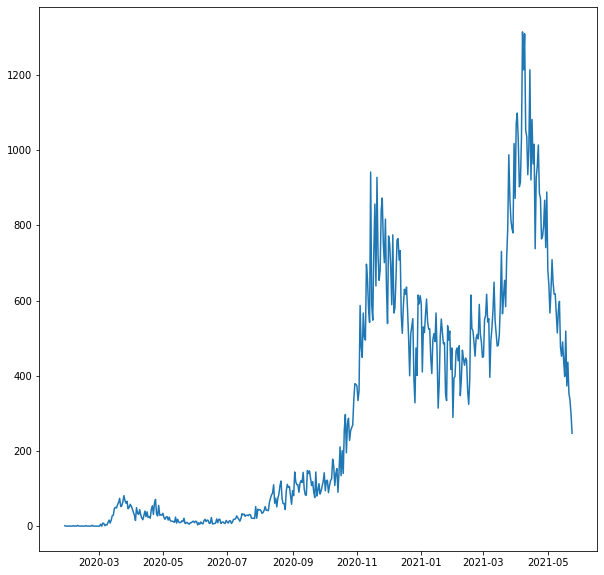

In [17]:
plt.figure(figsize=(10,10))
plt.plot(data)
plt.show()

# **Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model**

In [18]:
startDate = '2020-11-01'
data = data.loc[data.index > startDate]
splitDate = '2021-04-01'
train = data.loc[data.index < pd.to_datetime(splitDate)]
test = data.loc[data.index >= pd.to_datetime(splitDate)]
# train.index = pd.DatetimeIndex(train.index).to_period('D')
# test.index = pd.DatetimeIndex(test.index).to_period('D')

In [19]:
print(f'Train {train[:5]},\n Test {test[:5]}')
print(f'Train: {len(train)},\n Test: {len(test)}')

Train Reported Date
2020-11-02    334
2020-11-03    360
2020-11-04    587
2020-11-05    476
2020-11-06    449
Freq: D, Name: Diagnosed, dtype: int64,
 Test Reported Date
2021-04-01    1071
2021-04-02    1099
2021-04-03    1023
2021-04-04     903
2021-04-05     915
Freq: D, Name: Diagnosed, dtype: int64
Train: 150,
 Test: 54


In [20]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1790.073, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1824.327, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1811.462, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1791.639, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1822.491, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1789.519, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1800.642, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1790.960, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1776.742, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1790.670, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1783.548, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1775.7

In [21]:
test.index[-1]

Timestamp('2021-05-24 00:00:00', freq='D')

In [22]:
results = model.fit(train)

In [23]:
autoArimaPrediction = results.predict(n_periods=len(test))

In [24]:
len(test.index), len(autoArimaPrediction)

(54, 54)

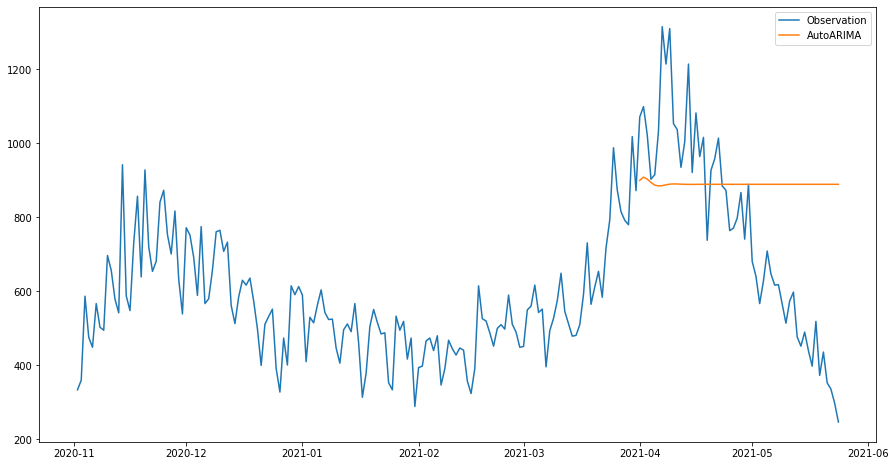

In [25]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(test.index, autoArimaPrediction, label='AutoARIMA')
plt.legend(handles=[l1,l2])
plt.show()

In [26]:
model = SARIMAX(train, order=(2,1,2))

In [27]:
results = model.fit(disp=True)

In [28]:
sarimaxPrediction = results.predict(start = splitDate, end = test.index[-1], dynamic=False)

In [29]:
sarimaxPrediction

2021-04-01    899.787241
2021-04-02    908.411650
2021-04-03    903.422342
2021-04-04    894.109764
2021-04-05    887.142390
2021-04-06    884.685411
2021-04-07    885.638173
2021-04-08    887.816591
2021-04-09    889.552277
2021-04-10    890.234236
2021-04-11    890.067665
2021-04-12    889.562151
2021-04-13    889.132448
2021-04-14    888.946924
2021-04-15    888.971257
2021-04-16    889.087529
2021-04-17    889.193269
2021-04-18    889.242935
2021-04-19    889.241010
2021-04-20    889.214531
2021-04-21    889.188665
2021-04-22    889.175546
2021-04-23    889.175035
2021-04-24    889.180996
2021-04-25    889.187286
2021-04-26    889.190712
2021-04-27    889.191076
2021-04-28    889.189751
2021-04-29    889.188231
2021-04-30    889.187345
2021-05-01    889.187199
2021-05-02    889.187488
2021-05-03    889.187853
2021-05-04    889.188080
2021-05-05    889.188130
2021-05-06    889.188068
2021-05-07    889.187981
2021-05-08    889.187923
2021-05-09    889.187908
2021-05-10    889.187920


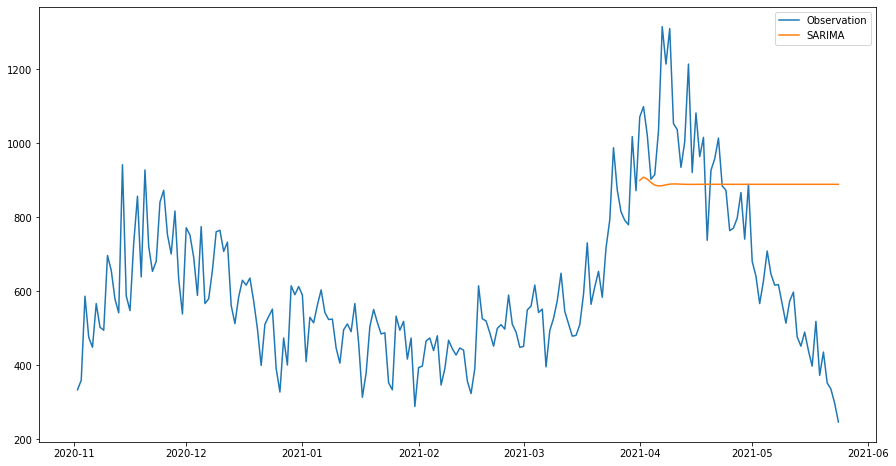

In [30]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(sarimaxPrediction, label='SARIMA')
plt.legend(handles=[l1,l2])

In [31]:
print('SARIMAX MAE = ', mean_absolute_error(sarimaxPrediction, test))

SARIMAX MAE =  243.21589460564954


# **Forcasting using Facebook's Prophet model**

In [32]:
trainDf = pd.DataFrame.from_dict({'ds':train.index, 'y':train})

In [33]:
trainDf.head()

,ds,y
Reported Date,,
2020-11-02,2020-11-02,334
2020-11-03,2020-11-03,360
2020-11-04,2020-11-04,587
2020-11-05,2020-11-05,476
2020-11-06,2020-11-06,449


In [34]:
prophetModel = Prophet()
prophetModel.fit(trainDf)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = prophetModel.make_future_dataframe(periods=data.shape[0]-train.shape[0])
prophetPrediction = prophetModel.predict(future)

In [36]:
prophetPrediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-02,632.296761,412.615228,653.808079,632.296761,632.296761,-87.958917,-87.958917,-87.958917,-87.958917,-87.958917,-87.958917,0.0,0.0,0.0,544.337844
1,2020-11-03,632.578046,521.564957,783.793779,632.578046,632.578046,22.138354,22.138354,22.138354,22.138354,22.138354,22.138354,0.0,0.0,0.0,654.716400
2,2020-11-04,632.859330,578.164482,810.150738,632.859330,632.859330,60.815421,60.815421,60.815421,60.815421,60.815421,60.815421,0.0,0.0,0.0,693.674752
3,2020-11-05,633.140615,558.831640,797.122332,633.140615,633.140615,47.113885,47.113885,47.113885,47.113885,47.113885,47.113885,0.0,0.0,0.0,680.254500
4,2020-11-06,633.421899,518.032675,778.519406,633.421899,633.421899,8.998770,8.998770,8.998770,8.998770,8.998770,8.998770,0.0,0.0,0.0,642.420669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-05-20,1027.008412,917.207338,1201.774702,954.802866,1094.015203,47.113885,47.113885,47.113885,47.113885,47.113885,47.113885,0.0,0.0,0.0,1074.122296
200,2021-05-21,1033.090270,901.065222,1176.631885,958.917631,1102.009163,8.998770,8.998770,8.998770,8.998770,8.998770,8.998770,0.0,0.0,0.0,1042.089040
201,2021-05-22,1039.172128,905.046911,1201.424883,963.001978,1110.202789,19.457009,19.457009,19.457009,19.457009,19.457009,19.457009,0.0,0.0,0.0,1058.629137
202,2021-05-23,1045.253986,825.343607,1111.742890,966.965070,1117.386638,-70.564522,-70.564522,-70.564522,-70.564522,-70.564522,-70.564522,0.0,0.0,0.0,974.689464


In [37]:
prophetPrediction = prophetPrediction.set_index('ds')
prophetFuture = prophetPrediction.yhat.loc[prophetPrediction.index >= splitDate]
print('Prophet MAE =', mean_absolute_error(prophetFuture, test))

Prophet MAE = 315.49152476578826


In [38]:
prophetFuture

ds
2021-04-01     776.111252
2021-04-02     744.077995
2021-04-03     760.618092
2021-04-04     676.678419
2021-04-05     665.365882
2021-04-06     781.545012
2021-04-07     826.303937
2021-04-08     818.684258
2021-04-09     786.651002
2021-04-10     803.191099
2021-04-11     719.251426
2021-04-12     707.938889
2021-04-13     824.118018
2021-04-14     868.876943
2021-04-15     861.257265
2021-04-16     829.224008
2021-04-17     845.764105
2021-04-18     761.824432
2021-04-19     750.511895
2021-04-20     866.691025
2021-04-21     911.449950
2021-04-22     903.830271
2021-04-23     871.797014
2021-04-24     888.337111
2021-04-25     804.397438
2021-04-26     793.084901
2021-04-27     909.264031
2021-04-28     954.022956
2021-04-29     946.403277
2021-04-30     914.370021
2021-05-01     930.910118
2021-05-02     846.970445
2021-05-03     835.657908
2021-05-04     951.837037
2021-05-05     996.595962
2021-05-06     988.976284
2021-05-07     956.943027
2021-05-08     973.483124
2021-05-0

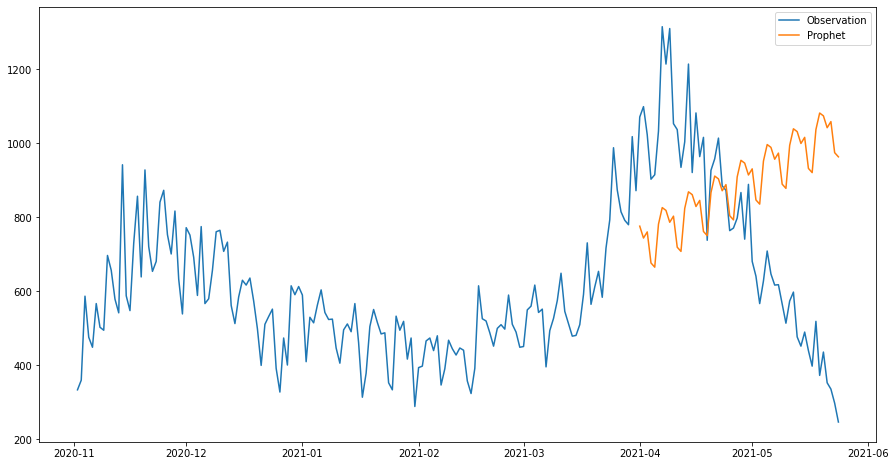

In [39]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(prophetFuture, label='Prophet')
plt.legend(handles=[l1,l2])
plt.show()

# Preparing the dataset for XGBOOST and NN

Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [40]:
data=pd.DataFrame(data)

In [41]:
data.head()

,Diagnosed
Reported Date,
2020-11-02,334
2020-11-03,360
2020-11-04,587
2020-11-05,476
2020-11-06,449


In [42]:
def featurize(t):
    X = pd.DataFrame()
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.Diagnosed
    return X, y

featurize(data)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,2,11,4,0,307,45
1,3,11,4,1,308,45
2,4,11,4,2,309,45
3,5,11,4,3,310,45
4,6,11,4,4,311,45


# Create training and test datasets by splitting the dataset, and perform data normalization.

In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [43]:
X_train, y_train = featurize(
data.loc[data.index < pd.to_datetime(splitDate)])
X_test, y_test = featurize(
data.loc[data.index >= pd.to_datetime(splitDate)])



Now let's discuss data normalization. We perform data normalization so as to make the range of values of the features, or the columns in the X_train table, as close as possible. For example, we have the features dayofweek and dayofyear. The range of values of dayofweek is from 1 to 7, whereas dayofyear is from 1 to 365. Having such large differences in the ranges of values will either slow down the training of the machine learning model or make it quite difficult. We solve this problem by applying normalization. There are several ways we can normalize the data with. Here I will choose the StandardScaler, which applies the following equation on each of the columns.

z = (x - u) / s

Here x is the column before scaling, u is thee mean and s is the standard deviation. So basically, we subtract the mean of each column from itself, then divide by the standard deviation of that column. To apply StandardScaler, we first fit the scaler object to the dataset:


In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Apply the scaling to both the training and test sets, as follows.

In [45]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

# Train the XGBOOST and NN models

First, create the XGBRegressor object which will represent the XGBOOST regression model.

In [46]:
XGModel = XGBRegressor(n_estimators = 7)

Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [47]:
XGModel.fit(scaled_train, y_train,
           eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
           verbose=True)
XGPredictions =  XGModel.predict(scaled_test)

[0]	validation_0-rmse:417.47748	validation_1-rmse:630.78522
[1]	validation_0-rmse:304.04608	validation_1-rmse:514.96613
[2]	validation_0-rmse:223.42348	validation_1-rmse:448.23718
[3]	validation_0-rmse:166.31364	validation_1-rmse:370.59070
[4]	validation_0-rmse:125.47314	validation_1-rmse:343.23401
[5]	validation_0-rmse:96.74112	validation_1-rmse:327.82578
[6]	validation_0-rmse:76.58263	validation_1-rmse:318.62024


Let us calculate the mean absolute error for the training.

In [48]:
print('XGModel MAE = ', mean_absolute_error(XGPredictions, y_test))

XGModel MAE =  259.9784692834925


Creation and training of the feedforward neural network model.

In [49]:
opt = adam_v2.Adam(learning_rate=0.001)
NNModel = Sequential()
NNModel.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NNModel.add(Dense(10))
NNModel.add(Dense(1))
NNModel.compile(loss='mean_absolute_error', optimizer=opt)
NNModel.fit(scaled_train, y_train, validation_data=(
scaled_test, y_test), epochs=220, verbose=1)
NNModelPrediction = NNModel.predict(scaled_test) 

Epoch 1/220
5/5 [==============================] - 11s 68ms/step - loss: 567.5667 - val_loss: 768.3375
Epoch 2/220
5/5 [==============================] - 0s 4ms/step - loss: 563.7600 - val_loss: 768.2970
Epoch 3/220
5/5 [==============================] - 0s 4ms/step - loss: 564.0711 - val_loss: 768.2495
Epoch 4/220
5/5 [==============================] - 0s 4ms/step - loss: 561.5766 - val_loss: 768.1980
Epoch 5/220
5/5 [==============================] - 0s 4ms/step - loss: 575.8061 - val_loss: 768.1522
Epoch 6/220
5/5 [==============================] - 0s 4ms/step - loss: 570.5740 - val_loss: 768.1053
Epoch 7/220
5/5 [==============================] - 0s 4ms/step - loss: 567.6101 - val_loss: 768.0547
Epoch 8/220
5/5 [==============================] - 0s 4ms/step - loss: 570.7128 - val_loss: 767.9969
Epoch 9/220
5/5 [==============================] - 0s 4ms/step - loss: 565.7142 - val_loss: 767.9320
Epoch 10/220
5/5 [==============================] - 0s 4ms/step - loss: 569.3172 - val_lo

Let's compare the MAE values.

In [50]:
print('XGBOOST MAE =', mean_absolute_error(XGPredictions, y_test))
print('Prophet MAE =', mean_absolute_error(prophetFuture, test))
print('SARIMAX MAE =', mean_absolute_error(sarimaxPrediction, test))
print('NN MAE =', mean_absolute_error(NNModelPrediction, test))

XGBOOST MAE = 259.9784692834925
Prophet MAE = 315.49152476578826
SARIMAX MAE = 243.21589460564954
NN MAE = 307.25430693449795


Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

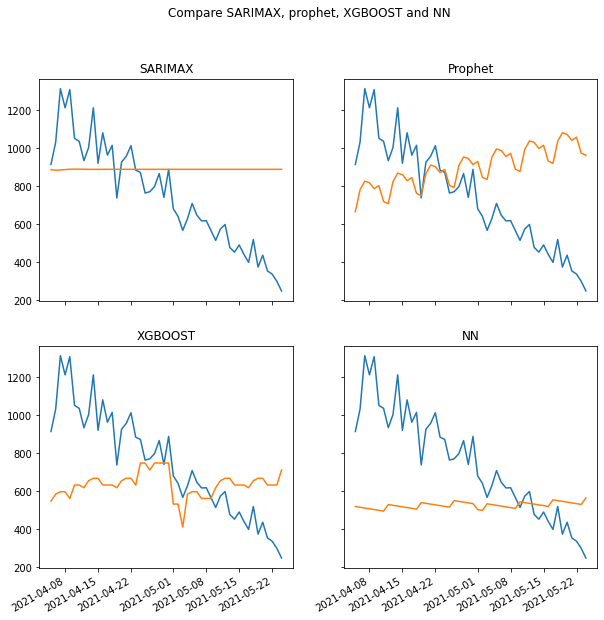

In [51]:

XGDf = pd.DataFrame({'y': XGPredictions.tolist()})
XGDf.index = y_test.index

NNdf = pd.DataFrame(NNModelPrediction)
NNdf.index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data.tail(50))
axs[0, 0].plot(sarimaxPrediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data.tail(50))
axs[0, 1].plot(prophetFuture.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data.tail(50))
axs[1, 0].plot(XGDf.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data.tail(50))
axs[1, 1].plot(NNdf.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)

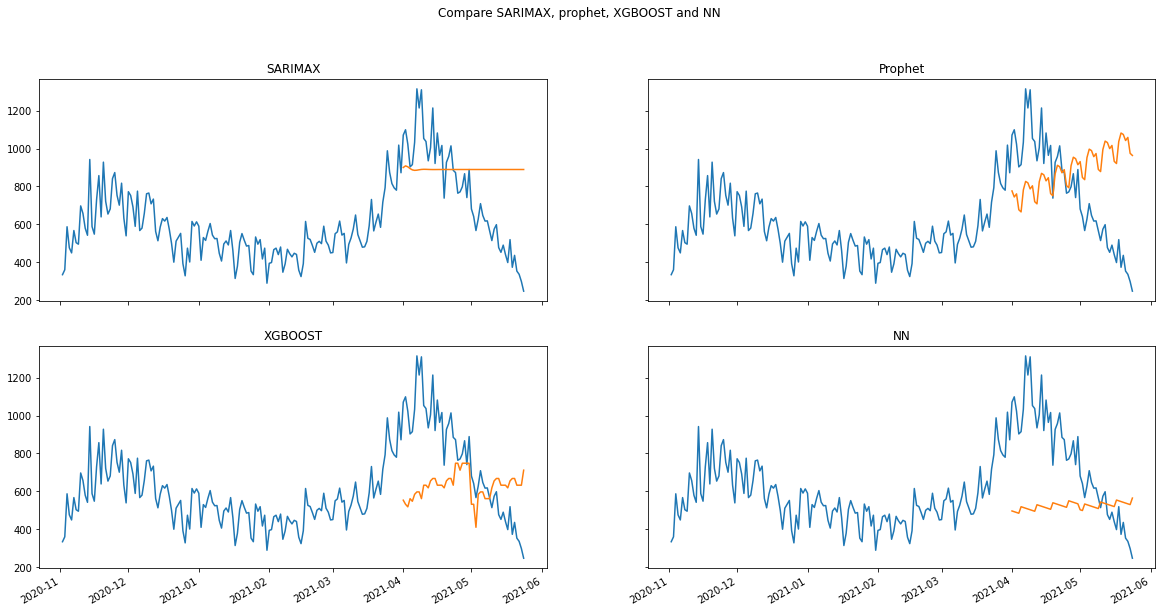

In [52]:

XGDf = pd.DataFrame({'y': XGPredictions.tolist()})
XGDf.index = y_test.index

NNdf = pd.DataFrame(NNModelPrediction)
NNdf.index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data)
axs[0, 0].plot(sarimaxPrediction)
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data)
axs[0, 1].plot(prophetFuture)
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data)
axs[1, 0].plot(XGDf)
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data)
axs[1, 1].plot(NNdf)
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)